In [1]:
# Import all the necessory libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt#visualization
%matplotlib inline

import seaborn as sns#visualization
import plotly.offline as py#visualization
import plotly.graph_objs as go#visualization
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# upload the datasets
happiness = pd.read_csv("happiness_clean.csv")
remote_job = pd.read_csv("Remote_Job_clean.csv")
mental_tech = pd.read_csv("Mental_tech_clean.csv")

## HAPPINESS REPORT

In [3]:
# Select features (X) and target (y)
X = happiness[["GDP per capita", "Healthy life expectancy","Social support"]]
y = happiness["Happiness Score"]

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

Training Data: (1210, 3), Testing Data: (303, 3)


### Comparison between linear Regresion, Random Forest and XGboost Models bold text

In [4]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
}

# Initialize a dictionary to store results
results = {}

# Train, predict, and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    r2 = r2_score(y_test, y_pred)
    
    # Calculate accuracy based on RMSE
    happiness_range = y_test.max() - y_test.min()
    accuracy = (1 - (rmse / happiness_range)) * 100
    
    # Store results
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Accuracy (%)': accuracy
    }

# Print results
for name, metrics in results.items():
    print(f"{name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    print()  # Add an empty line for better readability


Linear Regression Performance:
MAE: 0.56
RMSE: 0.76
R²: 0.33
Accuracy (%): 84.77

Random Forest Performance:
MAE: 0.41
RMSE: 0.66
R²: 0.49
Accuracy (%): 86.75

XGBoost Performance:
MAE: 0.42
RMSE: 0.67
R²: 0.48
Accuracy (%): 86.60



### Optimize XGBoost with Optuna

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the Optuna objective function
def objective(trial):
    # Suggest values for hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
    }

    # Train XGBoost model
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate using RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse  # Optuna will minimize this

# Run the Optuna study for 30 trials
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Get the best parameters
best_params_optuna = study.best_params
print("\nBest Hyperparameters:", best_params_optuna)

# Train the final model with optimized parameters
optimized_model = XGBRegressor(**best_params_optuna, random_state=42)
optimized_model.fit(X_train, y_train)

# Make predictions on test data
y_pred_optimized = optimized_model.predict(X_test)

# Evaluate the optimized model
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

# Calculate accuracy based on RMSE and the range of target values
happiness_range = y_test.max() - y_test.min()
accuracy_optimized = (1 - (rmse_optimized / happiness_range)) * 100

# Print results
print("\nModel Performance after Hyperparameter Tuning:")
print(f"RMSE: {rmse_optimized:.4f}")
print(f"MAE: {mae_optimized:.4f}")
print(f"R² Score: {r2_optimized:.4f}")
print(f"Estimated Accuracy: {accuracy_optimized:.2f}%")

[I 2025-03-21 21:04:20,371] A new study created in memory with name: no-name-bdb34855-8af1-4554-b1a4-86d3bea9c903
[I 2025-03-21 21:04:20,488] Trial 0 finished with value: 0.6544106138582567 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.06544979461278477, 'subsample': 0.8601574997222263, 'colsample_bytree': 0.6266272498168253}. Best is trial 0 with value: 0.6544106138582567.
[I 2025-03-21 21:04:20,699] Trial 1 finished with value: 0.6550499533191374 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.0436661712905933, 'subsample': 0.6740548708828441, 'colsample_bytree': 0.6840414340810278}. Best is trial 0 with value: 0.6544106138582567.
[I 2025-03-21 21:04:21,039] Trial 2 finished with value: 0.672238874911337 and parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.029150180887620083, 'subsample': 0.6196093436935062, 'colsample_bytree': 0.6366106849142023}. Best is trial 0 with value: 0.6544106138582567.
[I 2025-03-21 21:

[I 2025-03-21 21:04:26,563] Trial 28 finished with value: 0.6529053291881501 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.034803800197798336, 'subsample': 0.7459065780944086, 'colsample_bytree': 0.6657735517120603}. Best is trial 13 with value: 0.6466477575902828.
[I 2025-03-21 21:04:26,686] Trial 29 finished with value: 0.6537395382911341 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.026051025560106942, 'subsample': 0.8940413624863555, 'colsample_bytree': 0.7041509493390212}. Best is trial 13 with value: 0.6466477575902828.



Best Hyperparameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.015667897334955175, 'subsample': 0.9989876747930353, 'colsample_bytree': 0.8813919507726361}

Model Performance after Hyperparameter Tuning:
RMSE: 0.6466
MAE: 0.4122
R² Score: 0.5086
Estimated Accuracy: 86.98%


#### Explanation of the Code

Uses Optuna to search for the best hyperparameters via Bayesian Optimization.
Trains XGBoost with the best-found parameters and evaluates performance using RMSE, MAE, and R² Score.

### Feature Importance

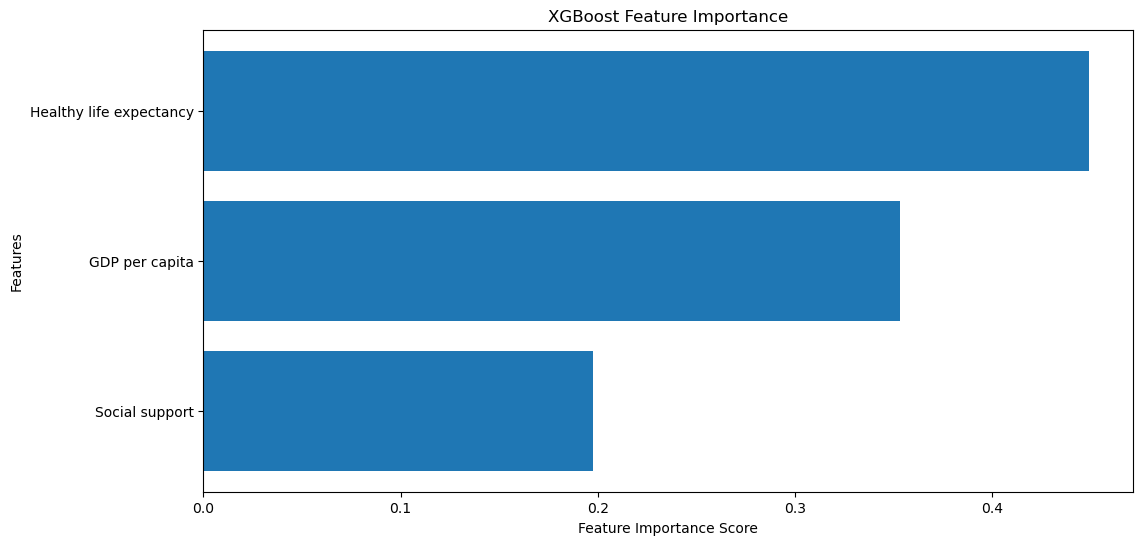

In [6]:
import matplotlib.pyplot as plt

# Get feature importance from the trained XGBoost model
importance = optimized_model.feature_importances_
feature_names = X.columns

# Create a DataFrame to sort features by importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)  # Sort from most to least important

# Plot sorted feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [24]:
!pip install ace-tools

  Obtaining dependency information for ace-tools from https://files.pythonhosted.org/packages/27/c4/402d3ae2ecbfe72fbdcb2769f55580f1c54a3ca110c44e1efc034516a499/ace_tools-0.0-py3-none-any.whl.metadata



Model Comparison Results:
                          RMSE       MAE  R² Score  Accuracy (%)
XGBoost               0.646648  0.412237  0.508637     86.983741
Random Forest         0.660845  0.417159  0.486825     86.697967
Linear Regression     0.756465  0.557268  0.327575     84.773254
Neural Network (MLP)  0.729561  0.545073  0.374554     85.314797


,RMSE,MAE,R² Score,Accuracy (%)
XGBoost,0.646648,0.412237,0.508637,86.983741
Random Forest,0.660845,0.417159,0.486825,86.697967
Linear Regression,0.756465,0.557268,0.327575,84.773254
Neural Network (MLP),0.729561,0.545073,0.374554,85.314797


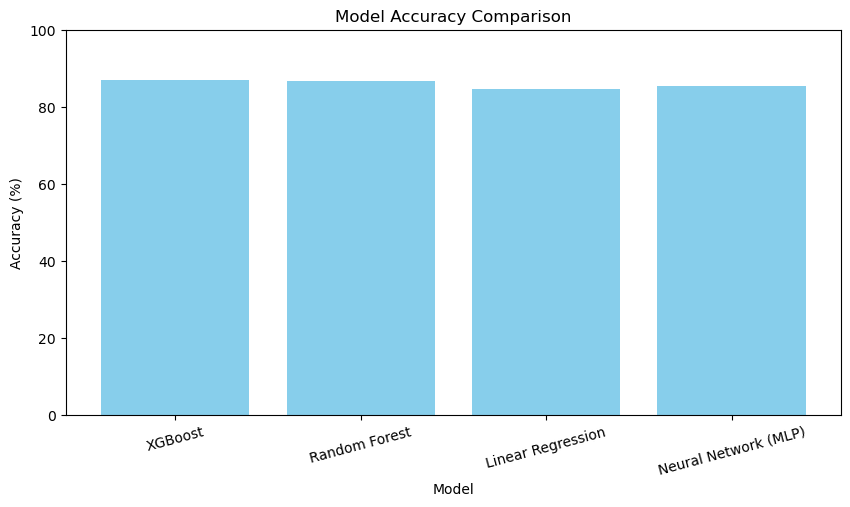

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define models
models = {
    "XGBoost": optimized_model,  # Assuming optimized_model is defined previously
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Linear Regression": LinearRegression(),
    "Neural Network (MLP)": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
}

# Dictionary to store results
model_results = {}

# Train & evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on test data

    # Compute evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Calculate accuracy based on RMSE and the range of target values
    happiness_range = y_test.max() - y_test.min()
    accuracy = (1 - (rmse / happiness_range)) * 100  # Correct accuracy calculation

    # Store results
    model_results[name] = {
        "RMSE": rmse,
        "MAE": mae,
        "R² Score": r2,
        "Accuracy (%)": accuracy,  # Correct accuracy calculation
    }

# Convert results to DataFrame
results_df = pd.DataFrame(model_results).T

# Display the results
print("\nModel Comparison Results:")
print(results_df)  # Display in console

from IPython.display import display
display(results_df)  # Displays as a nice table

# Plot Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.bar(results_df.index, results_df["Accuracy (%)"], color='skyblue')
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=15)
plt.ylim(0, 100)  # Set limit to 100% for better visualization
plt.show()


### Analyze the Best Model

In [8]:
# Identify the best model based on lowest RMSE
best_model_name = results_df["RMSE"].idxmin()
best_model_rmse = results_df.loc[best_model_name, "RMSE"]
best_model_r2 = results_df.loc[best_model_name, "R² Score"]

print(f"\nBest Model: {best_model_name}")
print(f"Lowest RMSE: {best_model_rmse:.4f}")
print(f"Highest R² Score: {best_model_r2:.4f}")

# Retrieve the best model instance
best_model = models[best_model_name]


Best Model: XGBoost
Lowest RMSE: 0.6466
Highest R² Score: 0.5086


### Hyperparameter Tuning Code (Using Optuna)

In [29]:
import optuna
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def objective(trial):
    if best_model_name == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        }
        model = XGBRegressor(**params, random_state=42)

    elif best_model_name == "Random Forest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        }
        model = RandomForestRegressor(**params, random_state=42)

    elif best_model_name == "Neural Network (MLP)":
        params = {
            "hidden_layer_sizes": (trial.suggest_int("layer1", 32, 128), trial.suggest_int("layer2", 16, 64)),
            "alpha": trial.suggest_float("alpha", 1e-5, 1e-1, log=True),
            "learning_rate_init": trial.suggest_float("learning_rate_init", 0.001, 0.1, log=True),
            "max_iter": 500,
        }
        model = MLPRegressor(**params, random_state=42)

    else:
        return float("inf")  # Return high error if no valid model

    # Train & evaluate the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse  # Optuna minimizes RMSE

# Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Get best parameters
best_hyperparams = study.best_params
print("\nBest Hyperparameters Found:", best_hyperparams)

# Train the best model with tuned hyperparameters
if best_model_name == "XGBoost":
    best_model = XGBRegressor(**best_hyperparams, random_state=42)
elif best_model_name == "Random Forest":
    best_model = RandomForestRegressor(**best_hyperparams, random_state=42)
elif best_model_name == "Neural Network (MLP)":
    best_model = MLPRegressor(**best_hyperparams, random_state=42)

# Train final best model
best_model.fit(X_train, y_train)
y_pred_final = best_model.predict(X_test)

# Evaluate final best model
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_mae = mean_absolute_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)

# Calculate accuracy based on RMSE and the range of target values
happiness_range = y_test.max() - y_test.min()
final_accuracy = (1 - (final_rmse / happiness_range)) * 100  # Correct accuracy calculation

# Print results
print("\nFinal Optimized Model Performance:")
print(f"RMSE: {final_rmse:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"R² Score: {final_r2:.4f}")
print(f"Estimated Accuracy: {final_accuracy:.2f}%")

[I 2025-03-01 09:20:53,517] A new study created in memory with name: no-name-a9664a3c-3fab-4470-acc1-6fbedd6bc9ee
[I 2025-03-01 09:20:53,942] Trial 0 finished with value: 0.6524570042099633 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.014009399796096321, 'subsample': 0.643835130657006, 'colsample_bytree': 0.8441083436785498}. Best is trial 0 with value: 0.6524570042099633.
[I 2025-03-01 09:20:54,298] Trial 1 finished with value: 0.674730909925995 and parameters: {'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.12549950340359595, 'subsample': 0.7769992103980099, 'colsample_bytree': 0.729520591354333}. Best is trial 0 with value: 0.6524570042099633.
[I 2025-03-01 09:20:54,499] Trial 2 finished with value: 0.6623106423651489 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05029491996284815, 'subsample': 0.6255105895198781, 'colsample_bytree': 0.9347761931407903}. Best is trial 0 with value: 0.6524570042099633.
[I 2025-03-01 09:2

[I 2025-03-01 09:21:00,708] Trial 28 finished with value: 0.6492934861788932 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.026894003388020494, 'subsample': 0.8005441664540914, 'colsample_bytree': 0.8160719254592989}. Best is trial 12 with value: 0.6470985261661626.
[I 2025-03-01 09:21:00,949] Trial 29 finished with value: 0.6516522944216324 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.02873260745530534, 'subsample': 0.7388163583283329, 'colsample_bytree': 0.8500321952214401}. Best is trial 12 with value: 0.6470985261661626.



Best Hyperparameters Found: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.029697654898032, 'subsample': 0.8173829821387005, 'colsample_bytree': 0.872429208194371}

Final Optimized Model Performance:
RMSE: 0.6471
MAE: 0.4117
R² Score: 0.5080
Estimated Accuracy: 86.97%


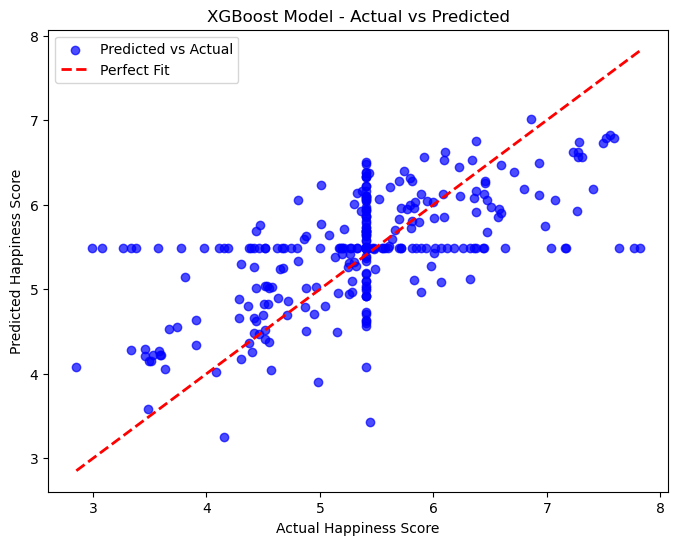

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Happiness Score")
plt.ylabel("Predicted Happiness Score")
plt.title("XGBoost Model - Actual vs Predicted")
plt.legend()
plt.show()

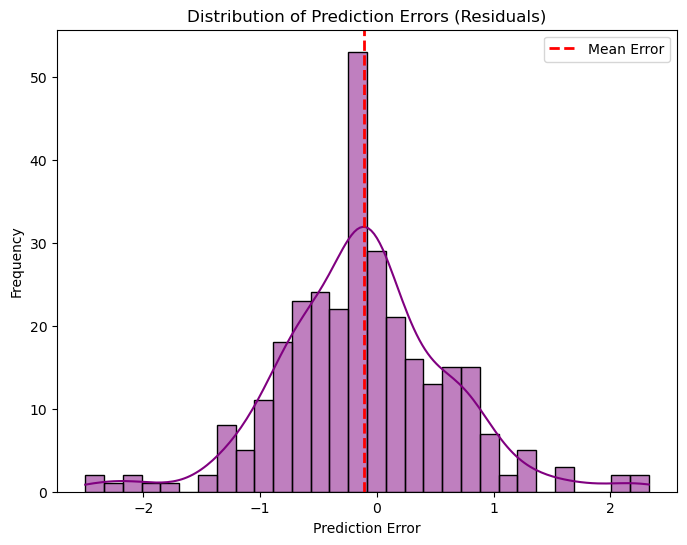

In [10]:
import seaborn as sns

errors = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(errors, bins=30, kde=True, color="purple")
plt.axvline(errors.mean(), color='red', linestyle='dashed', linewidth=2, label="Mean Error")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (Residuals)")
plt.legend()
plt.show()

## REMOTE JOB

In [35]:
remote_job

,Employee_ID,Age,Gender,Job_Role,Industry,Years_of_Experience,Work_Location,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,Stress_Level,Mental_Health_Condition,Access_to_Mental_Health_Resources,Productivity_Change,Social_Isolation_Rating,Satisfaction_with_Remote_Work,Company_Support_for_Remote_Work,Physical_Activity,Sleep_Quality,Region
0,EMP0001,32,Non-binary,HR,Healthcare,13,Hybrid,47,7,2,Medium,Depression,No,Decrease,1,Unsatisfied,1,Weekly,Good,Europe
1,EMP0002,40,Female,Data Scientist,IT,3,Remote,52,4,1,Medium,Anxiety,No,Increase,3,Satisfied,2,Weekly,Good,Asia
2,EMP0003,59,Non-binary,Software Engineer,Education,22,Hybrid,46,11,5,Medium,Anxiety,No,No Change,4,Unsatisfied,5,NaN,Poor,North America
3,EMP0004,27,Male,Software Engineer,Finance,20,Onsite,32,8,4,High,Depression,Yes,Increase,3,Unsatisfied,3,NaN,Poor,Europe
4,EMP0005,49,Male,Sales,Consulting,32,Onsite,35,12,2,High,NaN,Yes,Decrease,3,Unsatisfied,3,Weekly,Average,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,EMP4996,32,Male,Sales,Consulting,4,Onsite,24,2,5,High,Burnout,Yes,Decrease,4,Neutral,1,Weekly,Average,Asia
4996,EMP4997,39,Female,Sales,Healthcare,27,Onsite,48,15,1,Low,Depression,Yes,Decrease,1,Satisfied,1,NaN,Average,Africa
4997,EMP4998,42,Female,Sales,Healthcare,21,Hybrid,34,1,4,High,Burnout,No,Increase,3,Satisfied,1,Daily,Poor,Oceania
4998,EMP4999,27,Female,Sales,Healthcare,26,Remote,58,0,5,Low,NaN,Yes,Increase,3,Unsatisfied,4,Daily,Average,Asia


Model: Random Forest
Accuracy: 0.3367

              precision    recall  f1-score   support

     Neutral       0.33      0.30      0.31       502
   Satisfied       0.34      0.34      0.34       503
 Unsatisfied       0.34      0.37      0.36       495

    accuracy                           0.34      1500
   macro avg       0.34      0.34      0.34      1500
weighted avg       0.34      0.34      0.34      1500

Model: Support Vector Machine
Accuracy: 0.3267

              precision    recall  f1-score   support

     Neutral       0.19      0.01      0.02       502
   Satisfied       0.33      0.49      0.40       503
 Unsatisfied       0.32      0.49      0.39       495

    accuracy                           0.33      1500
   macro avg       0.28      0.33      0.27      1500
weighted avg       0.28      0.33      0.27      1500

Model: Logistic Regression
Accuracy: 0.3400

              precision    recall  f1-score   support

     Neutral       0.37      0.23      0.28       5

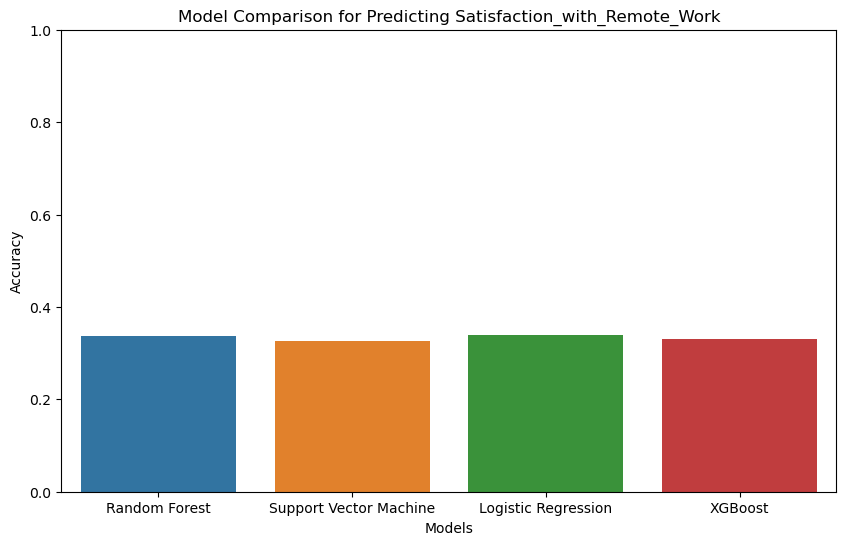

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Drop the Employee_ID column if it exists
remote_job_filtered = remote_job.drop(columns=['Employee_ID'], errors='ignore')

# 2. Select only the relevant features and target variable
y = remote_job_filtered['Satisfaction_with_Remote_Work']
X = remote_job_filtered[['Age', 'Hours_Worked_Per_Week', 'Years_of_Experience', 'Gender', 'Work_Location']]

# 3. Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# 4. Handle null values
if X.isnull().any().any():
    X = X.dropna()

# 5. Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# 6. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 7. Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# 8. Train models and evaluate
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"Model: {model_name}\nAccuracy: {accuracy:.4f}\n")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# 9. Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title('Model Comparison for Predicting Satisfaction_with_Remote_Work')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

### Hyperparameter Tuning Code for All models

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Drop the Employee_ID column if it exists
remote_job_filtered = remote_job.drop(columns=['Employee_ID'], errors='ignore')

# 2. Select only the relevant features and target variable
y = remote_job_filtered['Satisfaction_with_Remote_Work']
X = remote_job_filtered[['Age', 'Hours_Worked_Per_Week', 'Years_of_Experience', 'Gender', 'Work_Location']]

# 3. Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# 4. Handle null values
if X.isnull().any().any():
    X = X.dropna()

# 5. Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# 6. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 7. Define the hyperparameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

# 8. Train models with hyperparameter tuning
results = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"Model: {model_name}\nBest Parameters: {grid_search.best_params_}\nAccuracy: {accuracy:.4f}\n")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Model: Random Forest
Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.3447

              precision    recall  f1-score   support

     Neutral       0.37      0.33      0.35       502
   Satisfied       0.34      0.35      0.35       503
 Unsatisfied       0.33      0.36      0.34       495

    accuracy                           0.34      1500
   macro avg       0.35      0.34      0.34      1500
weighted avg       0.35      0.34      0.34      1500

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Model: Support Vector Machine
Best Parameters: {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.3267

              precision    recall  f1-score   support

     Neutral       0.19      0.01      0.02       502
   Satisfied       0.33      0.49      0.40       503
 Unsatisfied       0.32      0.49      0.39       495

    accuracy                           0.33      1500
   macro avg    

### Optimizing with Optuna

In [45]:
# BEST MODEL
# BEST MODEL
# BEST MODEL

import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Drop the Employee_ID column if it exists
remote_job_filtered = remote_job.drop(columns=['Employee_ID'], errors='ignore')

# 2. Select only the relevant features and target variable
y = remote_job_filtered['Satisfaction_with_Remote_Work']
X = remote_job_filtered[['Age', 'Hours_Worked_Per_Week', 'Years_of_Experience', 'Gender', 'Work_Location']]

# 3. Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# 4. Handle null values
if X.isnull().any().any():
    X = X.dropna()

# 5. Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# 6. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 7. Define the objective function for Optuna
def objective(trial):
    model_name = trial.suggest_categorical('model', ['Random Forest', 'SVM', 'Logistic Regression', 'XGBoost'])
    
    if model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 1, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
        
    elif model_name == 'SVM':
        C = trial.suggest_loguniform('C', 1e-3, 1e3)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
        
        model = SVC(C=C, kernel=kernel)
        
    elif model_name == 'Logistic Regression':
        C = trial.suggest_loguniform('C', 1e-3, 1e3)
        penalty = trial.suggest_categorical('penalty', ['l2'])
        
        model = LogisticRegression(C=C, penalty=penalty, solver='liblinear')
        
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 100)
        max_depth = trial.suggest_int('max_depth', 3, 7)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
        
        model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, use_label_encoder=False, eval_metric='logloss')
        
    # Fit the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# 8. Run the Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 9. Output the best hyperparameters
print("Best hyperparameters:", study.best_params)

# 10. Train the best model
best_model_name = study.best_params['model']
best_model_params = {k: v for k, v in study.best_params.items() if k != 'model'}

if best_model_name == 'Random Forest':
    best_model = RandomForestClassifier(**best_model_params)
elif best_model_name == 'SVM':
    best_model = SVC(**best_model_params)
elif best_model_name == 'Logistic Regression':
    best_model = LogisticRegression(**best_model_params)
elif best_model_name == 'XGBoost':
    best_model = XGBClassifier(**best_model_params, use_label_encoder=False, eval_metric='logloss')

# Fit the best model and evaluate
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best Model: {best_model_name}\nAccuracy: {accuracy:.4f}\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

[I 2025-03-12 11:02:15,314] A new study created in memory with name: no-name-a2d72756-82e7-41a5-b79b-636eaa864e00
[I 2025-03-12 11:02:17,735] Trial 0 finished with value: 0.338 and parameters: {'model': 'Random Forest', 'n_estimators': 160, 'max_depth': 18, 'min_samples_split': 2}. Best is trial 0 with value: 0.338.
[I 2025-03-12 11:02:18,075] Trial 1 finished with value: 0.336 and parameters: {'model': 'XGBoost', 'n_estimators': 80, 'max_depth': 6, 'learning_rate': 0.06528801865915387}. Best is trial 0 with value: 0.338.
[I 2025-03-12 11:02:20,154] Trial 2 finished with value: 0.324 and parameters: {'model': 'SVM', 'C': 0.094065211287143, 'kernel': 'rbf'}. Best is trial 0 with value: 0.338.
[I 2025-03-12 11:02:20,195] Trial 3 finished with value: 0.3373333333333333 and parameters: {'model': 'Logistic Regression', 'C': 0.22730271417061632, 'penalty': 'l2'}. Best is trial 0 with value: 0.338.
[I 2025-03-12 11:02:20,611] Trial 4 finished with value: 0.3253333333333333 and parameters: {'m

[I 2025-03-12 11:09:18,419] Trial 38 finished with value: 0.34 and parameters: {'model': 'XGBoost', 'n_estimators': 84, 'max_depth': 5, 'learning_rate': 0.11926326355052609}. Best is trial 23 with value: 0.356.
[I 2025-03-12 11:09:18,462] Trial 39 finished with value: 0.332 and parameters: {'model': 'Logistic Regression', 'C': 0.01786588741002762, 'penalty': 'l2'}. Best is trial 23 with value: 0.356.
[I 2025-03-12 11:09:18,725] Trial 40 finished with value: 0.3393333333333333 and parameters: {'model': 'XGBoost', 'n_estimators': 68, 'max_depth': 7, 'learning_rate': 0.08331830729362188}. Best is trial 23 with value: 0.356.
[I 2025-03-12 11:09:19,002] Trial 41 finished with value: 0.352 and parameters: {'model': 'XGBoost', 'n_estimators': 71, 'max_depth': 7, 'learning_rate': 0.12611437999607764}. Best is trial 23 with value: 0.356.
[I 2025-03-12 11:09:19,256] Trial 42 finished with value: 0.346 and parameters: {'model': 'XGBoost', 'n_estimators': 64, 'max_depth': 7, 'learning_rate': 0.139

Best hyperparameters: {'model': 'XGBoost', 'n_estimators': 79, 'max_depth': 6, 'learning_rate': 0.14804180543087622}
Best Model: XGBoost
Accuracy: 0.3560

              precision    recall  f1-score   support

     Neutral       0.37      0.34      0.36       502
   Satisfied       0.35      0.37      0.36       503
 Unsatisfied       0.35      0.36      0.35       495

    accuracy                           0.36      1500
   macro avg       0.36      0.36      0.36      1500
weighted avg       0.36      0.36      0.36      1500



### SAVING THE BEST MODEL (XG BOOST)

In [50]:
import joblib

# Assuming `best_model` is the optimized XGBoost model
best_model.fit(X_train, y_train)  # Train the model with your data

# Save the model to a file
joblib.dump(best_model, 'xgboost_model_remote.pkl')

print("XGBoost model saved as 'xgboost_model_remote.pkl'")


XGBoost model saved as 'xgboost_model_remote.pkl'


### FEATURE IMPORTANCE

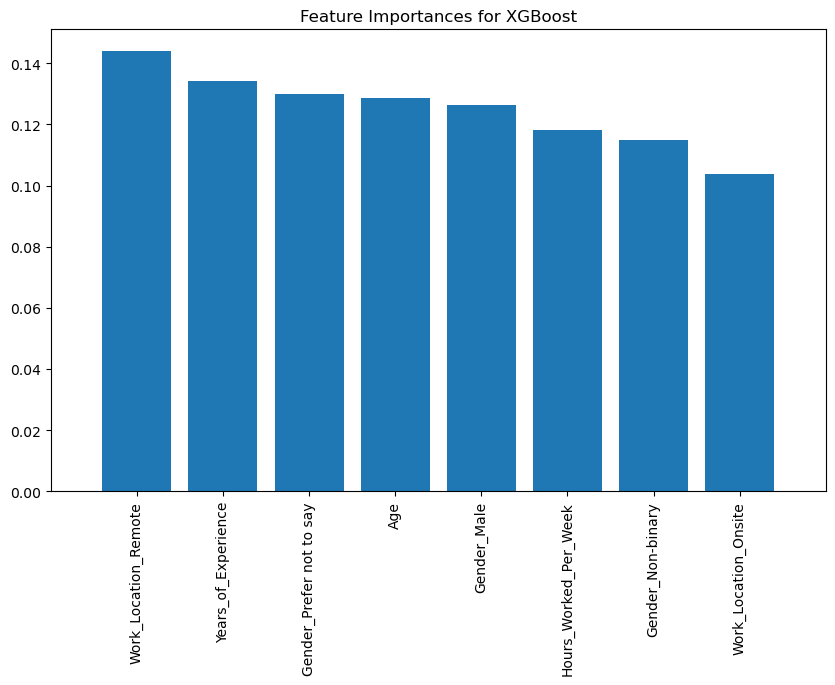

In [51]:
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np


# Feature importance for XGBoost
importances = best_model.feature_importances_

# Plot feature importances
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances for XGBoost")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## MENTAL TECH

In [17]:
mental_tech

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27,37,Male,United States,IL,No,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,No comment
1,2014-08-27,44,Male,United States,IN,No,No,No,Rarely,>1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,No comment
2,2014-08-27,32,Male,Canada,CA,No,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,No comment
3,2014-08-27,31,Male,United Kingdom,CA,No,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,No comment
4,2014-08-27,31,Male,United States,TX,No,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,No comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2015-09-12,26,Male,United Kingdom,CA,No,No,Yes,Sometimes,26-100,...,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,No comment
1255,2015-09-26,32,Male,United States,IL,No,Yes,Yes,Often,26-100,...,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,No comment
1256,2015-11-07,34,Male,United States,CA,No,Yes,Yes,Sometimes,>1000,...,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,No comment
1257,2015-11-30,46,Female,United States,NC,No,No,No,Sometimes,100-500,...,Don't know,Yes,No,No,No,No,No,No,No,No comment


In [23]:
from sklearn.preprocessing import LabelEncoder

# Convertir la variable objetivo a numérica
le = LabelEncoder()
y = le.fit_transform(mental_tech["treatment"])

# Ver las clases originales y sus correspondientes etiquetas numéricas
print("Clases originales:", le.classes_)
print("Valores numéricos correspondientes:", list(range(len(le.classes_))))

Clases originales: ['No' 'Yes']
Valores numéricos correspondientes: [0, 1]


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assume you have already loaded your dataset into a DataFrame called 'data'
# Select features (X) and target (y)
X = mental_tech[["work_interfere", "family_history","Country", "care_options", "benefits"]]
y = mental_tech["treatment"]

# Convert categorical variables into dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

Training Data: (1007, 55), Testing Data: (252, 55)


### BEST MODEL WITH CORRELATION MATRIX

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert categorical variables into dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', probability=True, random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
}

# Initialize a list to store results
results = []

# Train and evaluate models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append([model_name, accuracy, precision, recall, f1])

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])

# Sort results by accuracy in descending order
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Print model performance
print("\nModel Performance Results (sorted by Accuracy):")
print(results_df.reset_index(drop=True))



Model Performance Results (sorted by Accuracy):
                    Model  Accuracy  Precision    Recall  F1-score
0     Logistic Regression  0.738095   0.739322  0.738095  0.737963
1           Random Forest  0.734127   0.735628  0.734127  0.733939
2  Support Vector Machine  0.730159   0.732670  0.730159  0.729750
3       Gradient Boosting  0.726190   0.728305  0.726190  0.725858
4    Neural Network (MLP)  0.722222   0.725485  0.722222  0.721609
5           Decision Tree  0.706349   0.709443  0.706349  0.705701


### MODEL WITH FEATURE IMPORTANCE VARIABLE lESS ACCURACY

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Drop irrelevant columns
df_cleaned1 = mental_tech.drop(columns=['Timestamp', 'comments', 'state'])

# Encode categorical variables
label_encoders = {}
for col in df_cleaned1.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_cleaned1[col] = le.fit_transform(df_cleaned1[col])
    label_encoders[col] = le

# Define features (X) and target variable (y)
X1 = df_cleaned1[["work_interfere", "family_history", "coworkers", "care_options", "Age"]]
y1 = df_cleaned1['treatment']

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', probability=True, random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
}

# Initialize a list to store results
results = []

# Train and evaluate models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append([model_name, accuracy, precision, recall, f1])

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])

# Sort results by accuracy in descending order
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Print model performance
print("\nModel Performance Results (sorted by Accuracy):")
print(results_df.reset_index(drop=True))


Model Performance Results (sorted by Accuracy):
                    Model  Accuracy  Precision    Recall  F1-score
0       Gradient Boosting  0.706349   0.708679  0.706349  0.705905
1    Neural Network (MLP)  0.670635   0.686330  0.670635  0.664921
2     Logistic Regression  0.666667   0.672827  0.666667  0.664577
3           Random Forest  0.658730   0.662809  0.658730  0.657372
4           Decision Tree  0.634921   0.639330  0.634921  0.633074
5  Support Vector Machine  0.611111   0.611237  0.611111  0.611136


### Hyperparameter Tuning Code for All models

In [22]:
# BEST MODEL
# BEST MODEL
# BEST MODEL

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grids for each model
param_grid_logistic = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

param_grid_tree = {
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

param_grid_forest = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

param_grid_gbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_svc = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (50, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [500, 1000]
}

# Initialize models
models = {
    "Logistic Regression": (LogisticRegression(random_state=42), param_grid_logistic),
    "Decision Tree": (DecisionTreeClassifier(random_state=42), param_grid_tree),
    "Random Forest": (RandomForestClassifier(random_state=42), param_grid_forest),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=42), param_grid_gbm),
    "Support Vector Machine": (SVC(random_state=42), param_grid_svc),
    "Neural Network (MLP)": (MLPClassifier(random_state=42), param_grid_mlp)
}

# Initialize a list to store results
results = []

# Train and evaluate models with GridSearchCV
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"Best Parameters for {model_name}: {best_params}")

    # Train the best model
    best_model = model.set_params(**best_params)
    best_model.fit(X_train, y_train)

    # Predictions
    y_pred_best = best_model.predict(X_test)

    # Evaluate the optimized model
    accuracy = accuracy_score(y_test, y_pred_best)
    precision = precision_score(y_test, y_pred_best, average='weighted')
    recall = recall_score(y_test, y_pred_best, average='weighted')
    f1 = f1_score(y_test, y_pred_best, average='weighted')

    results.append([model_name, accuracy, precision, recall, f1])

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])

# Sort results by accuracy in descending order
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Print model performance
print("\nOptimized Model Performance Results (sorted by Accuracy):")
print(results_df.reset_index(drop=True))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for Decision Tree: {'max_depth': 3, 'min_samples_split': 2}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Random Forest: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Support Vector Machine: {'C': 0.1, 'kernel': 'linear'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Neural Network (MLP): {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'max_iter': 500}

Optimized Model Performance Results (sorted by Accuracy):
     

## SAVING THE RANDOM FOREST MODEL

In [24]:
import joblib

# Assuming `best_model` is the optimized Random Forest model
best_model_Tech = RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=100, random_state=42)
best_model_Tech.fit(X_train, y_train)  # Train the model with your data

# Save the model to a file
joblib.dump(best_model_Tech, 'random_forest_model.pkl')

print("Random Forest model saved as 'random_forest_model.pkl'")

Random Forest model saved as 'random_forest_model.pkl'


In [40]:
## Apliying just OPTUNA for Random Forest

import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Make sure to split your dataset before using Optuna.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    
    # Create the Random Forest model with the suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Show the best results
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2025-03-11 18:20:20,775] A new study created in memory with name: no-name-131372ba-80e5-41b1-8744-47ab13212f60
[I 2025-03-11 18:20:21,090] Trial 0 finished with value: 0.7222222222222222 and parameters: {'n_estimators': 118, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7222222222222222.
[I 2025-03-11 18:20:21,615] Trial 1 finished with value: 0.7182539682539683 and parameters: {'n_estimators': 157, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7222222222222222.
[I 2025-03-11 18:20:22,422] Trial 2 finished with value: 0.7023809523809523 and parameters: {'n_estimators': 274, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7222222222222222.
[I 2025-03-11 18:20:22,814] Trial 3 finished with value: 0.7222222222222222 and parameters: {'n_estimators': 127, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value:

[I 2025-03-11 18:20:43,819] Trial 36 finished with value: 0.7380952380952381 and parameters: {'n_estimators': 192, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.7380952380952381.
[I 2025-03-11 18:20:44,317] Trial 37 finished with value: 0.7222222222222222 and parameters: {'n_estimators': 121, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 10 with value: 0.7380952380952381.
[I 2025-03-11 18:20:44,959] Trial 38 finished with value: 0.7341269841269841 and parameters: {'n_estimators': 156, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.7380952380952381.
[I 2025-03-11 18:20:45,776] Trial 39 finished with value: 0.7380952380952381 and parameters: {'n_estimators': 180, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.7380952380952381.
[I 2025-03-11 18:20:46,500] Trial 40 finished with value: 0.7182539682539683 and par

[I 2025-03-11 18:21:06,462] Trial 72 finished with value: 0.7380952380952381 and parameters: {'n_estimators': 183, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 59 with value: 0.7420634920634921.
[I 2025-03-11 18:21:06,743] Trial 73 finished with value: 0.7341269841269841 and parameters: {'n_estimators': 60, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 59 with value: 0.7420634920634921.
[I 2025-03-11 18:21:07,125] Trial 74 finished with value: 0.7380952380952381 and parameters: {'n_estimators': 71, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 59 with value: 0.7420634920634921.
[I 2025-03-11 18:21:07,800] Trial 75 finished with value: 0.7380952380952381 and parameters: {'n_estimators': 172, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 59 with value: 0.7420634920634921.
[I 2025-03-11 18:21:08,286] Trial 76 finished with value: 0.7341269841269841 and param

Best trial:
  Value: 0.7420634920634921
  Params:
    n_estimators: 79
    max_depth: 22
    min_samples_split: 9
    min_samples_leaf: 1


## OPTIMIZING CODE BY OPTUNA

In [21]:
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the objective function for Optuna
def objective(trial):
    # Select model to optimize
    model_name = trial.suggest_categorical("model", [
        "Logistic Regression", 
        "Decision Tree", 
        "Random Forest", 
        "Gradient Boosting", 
        "Support Vector Machine", 
        "Neural Network (MLP)"
    ])
    
    if model_name == "Logistic Regression":
        C = trial.suggest_loguniform("C", 1e-5, 1e5)
        penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
        solver = trial.suggest_categorical("solver", ["liblinear", "saga"])
        model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=42)

    elif model_name == "Decision Tree":
        max_depth = trial.suggest_int("max_depth", 1, 10)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)

    elif model_name == "Random Forest":
        n_estimators = trial.suggest_int("n_estimators", 100, 500)
        max_depth = trial.suggest_int("max_depth", 1, 10)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)

    elif model_name == "Gradient Boosting":
        n_estimators = trial.suggest_int("n_estimators", 100, 500)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 0.1)
        max_depth = trial.suggest_int("max_depth", 1, 10)
        model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)

    elif model_name == "Support Vector Machine":
        C = trial.suggest_loguniform("C", 1e-5, 1e5)
        kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
        model = SVC(C=C, kernel=kernel, probability=True, random_state=42)

    elif model_name == "Neural Network (MLP)":
        hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [(50,), (50, 50), (100,)])
        activation = trial.suggest_categorical("activation", ["tanh", "relu"])
        alpha = trial.suggest_loguniform("alpha", 1e-5, 1e-1)
        max_iter = trial.suggest_int("max_iter", 500, 1000)
        model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, alpha=alpha, max_iter=max_iter, random_state=42)

    # Evaluate the model with cross-validation
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy')
    return score.mean()


# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create the study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train the best model with the best parameters
best_model_name = trial.params.pop('model')
if best_model_name == "Logistic Regression":
    best_model = LogisticRegression(**trial.params, random_state=42)
elif best_model_name == "Decision Tree":
    best_model = DecisionTreeClassifier(**trial.params, random_state=42)
elif best_model_name == "Random Forest":
    best_model = RandomForestClassifier(**trial.params, random_state=42)
elif best_model_name == "Gradient Boosting":
    best_model = GradientBoostingClassifier(**trial.params, random_state=42)
elif best_model_name == "Support Vector Machine":
    best_model = SVC(**trial.params, probability=True, random_state=42)
elif best_model_name == "Neural Network (MLP)":
    best_model = MLPClassifier(**trial.params, random_state=42)

# Train the best model
best_model.fit(X_train, y_train)

# Predictions
y_pred_best = best_model.predict(X_test)

# Evaluate the optimized model
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best, average='weighted')
recall = recall_score(y_test, y_pred_best, average='weighted')
f1 = f1_score(y_test, y_pred_best, average='weighted')

# Display results
best_model_results = pd.DataFrame(
    [["Optimized Model", accuracy, precision, recall, f1]],
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"]
)

print("\nOptimized Model Performance:")
print(best_model_results)

[I 2025-03-10 19:48:24,936] A new study created in memory with name: no-name-bb432bdd-3e8d-45a9-9680-4682026a08a8
[I 2025-03-10 19:48:29,986] Trial 0 finished with value: 0.5015023890448747 and parameters: {'model': 'Logistic Regression', 'C': 0.0003049467750475723, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 0 with value: 0.5015023890448747.
[I 2025-03-10 19:48:34,806] Trial 1 finished with value: 0.7348406482439288 and parameters: {'model': 'Random Forest', 'n_estimators': 498, 'max_depth': 8, 'min_samples_split': 3}. Best is trial 1 with value: 0.7348406482439288.
[I 2025-03-10 19:48:39,379] Trial 2 finished with value: 0.7189744347569086 and parameters: {'model': 'Random Forest', 'n_estimators': 429, 'max_depth': 2, 'min_samples_split': 3}. Best is trial 1 with value: 0.7348406482439288.
[I 2025-03-10 19:48:41,946] Trial 3 finished with value: 0.7467760208856706 and parameters: {'model': 'Logistic Regression', 'C': 8618.938204549358, 'penalty': 'l1', 'solver': 'saga'}. Best i

[I 2025-03-10 19:49:14,797] Trial 33 finished with value: 0.7517314418008965 and parameters: {'model': 'Neural Network (MLP)', 'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 1.3803865973247549e-05, 'max_iter': 553}. Best is trial 17 with value: 0.7517314418008965.
[I 2025-03-10 19:49:14,849] Trial 34 finished with value: 0.7110437909462587 and parameters: {'model': 'Decision Tree', 'max_depth': 3, 'min_samples_split': 2}. Best is trial 17 with value: 0.7517314418008965.
[I 2025-03-10 19:49:15,175] Trial 35 finished with value: 0.7159745825328802 and parameters: {'model': 'Support Vector Machine', 'C': 0.0847729041978662, 'kernel': 'linear'}. Best is trial 17 with value: 0.7517314418008965.
[I 2025-03-10 19:49:16,998] Trial 36 finished with value: 0.7249495098763608 and parameters: {'model': 'Gradient Boosting', 'n_estimators': 368, 'learning_rate': 0.0005979344134628351, 'max_depth': 5}. Best is trial 17 with value: 0.7517314418008965.
[I 2025-03-10 19:49:18,217] Trial 37 

[I 2025-03-10 19:49:49,027] Trial 65 finished with value: 0.7517314418008965 and parameters: {'model': 'Neural Network (MLP)', 'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 6.135955274999182e-05, 'max_iter': 574}. Best is trial 17 with value: 0.7517314418008965.
[I 2025-03-10 19:49:52,250] Trial 66 finished with value: 0.5054627850844786 and parameters: {'model': 'Gradient Boosting', 'n_estimators': 491, 'learning_rate': 1.299240813882428e-05, 'max_depth': 6}. Best is trial 17 with value: 0.7517314418008965.
[I 2025-03-10 19:49:54,714] Trial 67 finished with value: 0.7477710457612925 and parameters: {'model': 'Neural Network (MLP)', 'hidden_layer_sizes': (50,), 'activation': 'relu', 'alpha': 0.005919510291746821, 'max_iter': 867}. Best is trial 17 with value: 0.7517314418008965.
[I 2025-03-10 19:49:55,517] Trial 68 finished with value: 0.7209546327767105 and parameters: {'model': 'Random Forest', 'n_estimators': 216, 'max_depth': 2, 'min_samples_split': 2}. Best is trial 

[I 2025-03-10 19:50:27,382] Trial 96 finished with value: 0.6991379734988423 and parameters: {'model': 'Decision Tree', 'max_depth': 2, 'min_samples_split': 4}. Best is trial 17 with value: 0.7517314418008965.
[I 2025-03-10 19:50:28,604] Trial 97 finished with value: 0.7517314418008965 and parameters: {'model': 'Neural Network (MLP)', 'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 9.363444913001712e-05, 'max_iter': 635}. Best is trial 17 with value: 0.7517314418008965.
[I 2025-03-10 19:50:28,985] Trial 98 finished with value: 0.7060538889709866 and parameters: {'model': 'Support Vector Machine', 'C': 0.01446319314466365, 'kernel': 'linear'}. Best is trial 17 with value: 0.7517314418008965.
[I 2025-03-10 19:50:30,254] Trial 99 finished with value: 0.7517314418008965 and parameters: {'model': 'Neural Network (MLP)', 'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 7.019462176015564e-05, 'max_iter': 670}. Best is trial 17 with value: 0.7517314418008965.


Best trial:
  Value: 0.7517314418008965
  Params:
    model: Neural Network (MLP)
    hidden_layer_sizes: (50,)
    activation: tanh
    alpha: 3.5915634968096885e-05
    max_iter: 561

Optimized Model Performance:
             Model  Accuracy  Precision    Recall  F1-score
0  Optimized Model  0.722222   0.722937  0.722222   0.72217


### Feature Importance


Top Features Contributing to Predictions:
                  Feature  Importance
3      family_history_Yes    0.346328
52       care_options_Yes    0.189200
0    work_interfere_Often    0.146609
54           benefits_Yes    0.075173
51  care_options_Not sure    0.045341


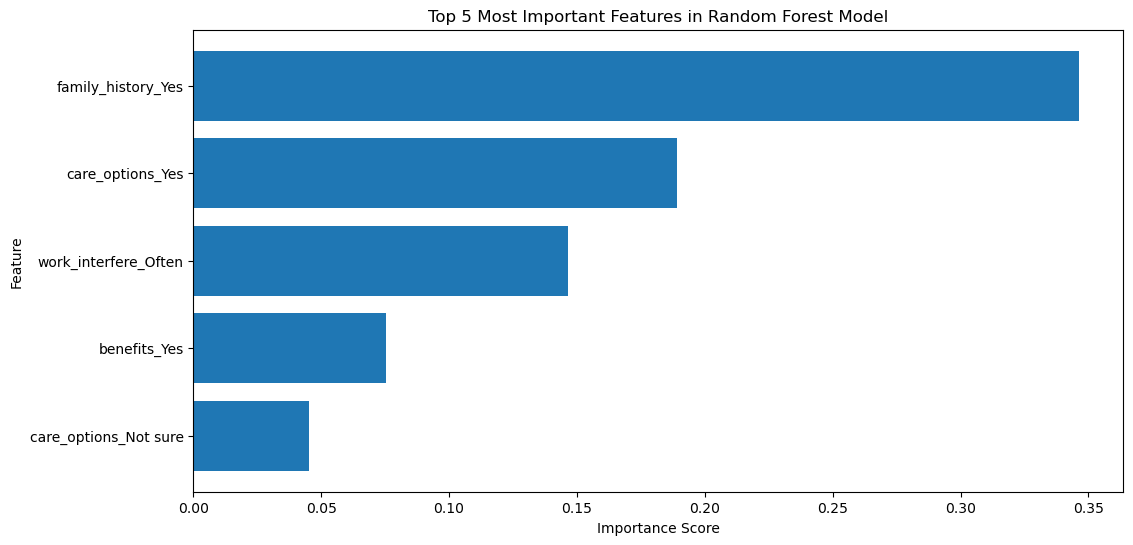

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `best_model_Tech` is your optimized Random Forest model
# Make sure that `X_train` is your DataFrame with the features used to train the model

# Get the feature importances from the trained model
feature_importance = best_model_Tech.feature_importances_

# Create a DataFrame to display the feature importance values
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Print the feature importance table
print("\nTop Features Contributing to Predictions:")
print(feature_importance_df.head(5))

# Plot the top 10 most important features
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:5], feature_importance_df['Importance'][:5])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 5 Most Important Features in Random Forest Model")
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.show()

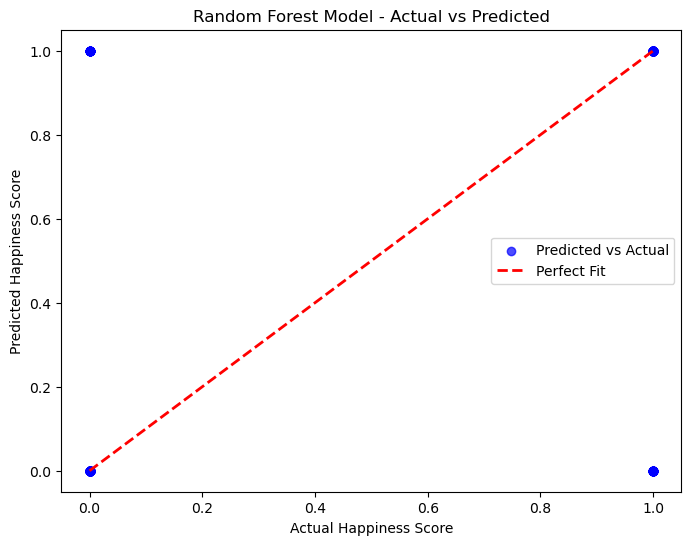

In [25]:
import matplotlib.pyplot as plt

# Make predictions with the Random Forest model
y_pred = best_model_Tech.predict(X_test)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Happiness Score")
plt.ylabel("Predicted Happiness Score")
plt.title("Random Forest Model - Actual vs Predicted")
plt.legend()
plt.show()

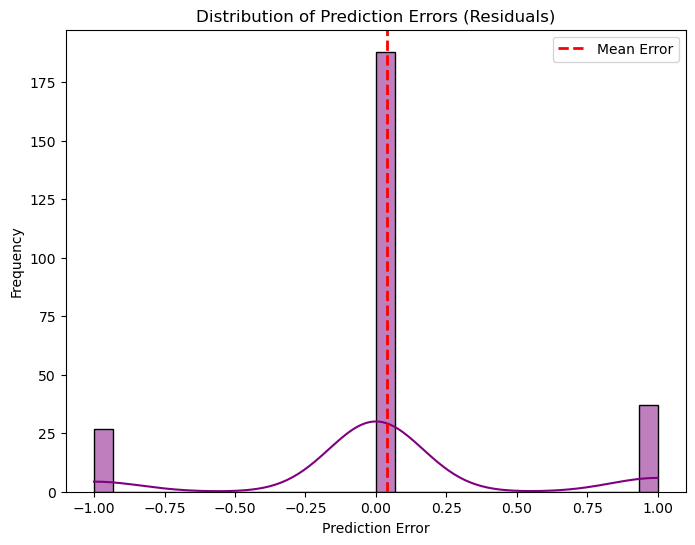

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure to have the model predictions
y_pred = best_model_Tech.predict(X_test)

# Calculate prediction errors
errors = y_test - y_pred 

# Create a plot of the error distribution
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True, color="purple")
plt.axvline(errors.mean(), color='red', linestyle='dashed', linewidth=2, label="Mean Error")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (Residuals)")
plt.legend()
plt.show()


### Test Hypotheses

Analyze the relationship between remote work and mental health treatment

In [34]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming you have already loaded your dataset into a DataFrame called 'data'
# Create a new column indicating whether the person works remotely or not
mental_tech['remote_work'] = mental_tech['self_employed'].apply(lambda x: 'Yes' if x == 'Yes' else 'No')

# Create a contingency table
contingency_table = pd.crosstab(mental_tech['remote_work'], mental_tech['treatment'])

# Perform the chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Show results
print("Contingency Table:")
print(contingency_table)
print(f"\nChi-square: {chi2}, p-value: {p}")

# Interpret the result
alpha = 0.05  # Significance level
if p < alpha:
    print("Reject the null hypothesis: there is a significant association between remote work and treatment.")
else:
    print("Fail to reject the null hypothesis: there is no significant association between remote work and treatment.")

Contingency Table:
treatment     No  Yes
remote_work          
No           554  559
Yes           68   78

Chi-square: 0.40848425328984905, p-value: 0.5227398427535908
Fail to reject the null hypothesis: there is no significant association between remote work and treatment.


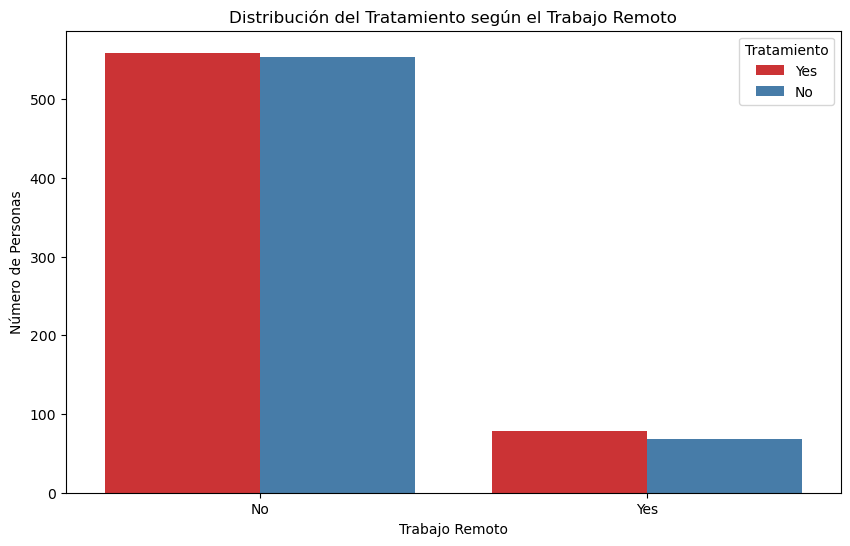

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already created the 'remote_work' column as shown earlier

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(data=mental_tech, x='remote_work', hue='treatment', palette='Set1')

# Add labels and title
plt.title('Distribution of Treatment by Remote Work')
plt.xlabel('Remote Work')
plt.ylabel('Number of People')
plt.legend(title='Treatment', loc='upper right')

# Show the plot
plt.show()